In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.0.0'

# Get the data

In [3]:
# fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# rescale
x_train_full, x_test = x_train_full/255., x_test/255.
# Add channels last
x_train_full, x_test = np.expand_dims(x_train_full, axis=-1), np.expand_dims(x_test, axis=-1)
# Split train / validation
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, test_size=5000)
# Labels 
labels_map = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [4]:
print('Train:', x_train.shape, x_train.dtype, y_train.shape, y_train.dtype)
print('Valid:', x_val.shape, x_val.dtype, y_val.shape, y_val.dtype)
print('Test :', x_test.shape, x_test.dtype, y_test.shape, y_test.dtype)

Train: (55000, 28, 28, 1) float64 (55000,) uint8
Valid: (5000, 28, 28, 1) float64 (5000,) uint8
Test : (10000, 28, 28, 1) float64 (10000,) uint8


# Define the model

In this exercise we define a model with an auxiliary output. To add an auxiliary output is a technique used in deep networks to reduce the vanishing of gradients, to stabilize the training and as regularisation (as it impose an constrains on the lower layers).

In this small example it is unlikely that the extra loss will have a positive impact but for deeper network (e.g. GoogLeNet) it has been proven to be really effective. 

In [5]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense,\
                                    LeakyReLU, MaxPooling2D, Dropout
def build_model(x):
    x = Conv2D(16, 3, padding='same', activation="relu", use_bias=True)(x)
    x = Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    aux_out = Conv2D(4, 1, padding='same', use_bias=True)(x)
    aux_out = Flatten()(aux_out)
    aux_out = Dropout(0.5)(aux_out)
    aux_out = Dense(10, activation='softmax', name="aux_output")(aux_out)

    x = Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    main_out = Conv2D(16, 1, padding='same', use_bias=True)(x)
    main_out = Flatten()(main_out)
    main_out = Dropout(0.5)(main_out)
    main_out = Dense(10, activation='softmax', name="main_output")(main_out)
    return main_out, aux_out

In [6]:
input_ = Input(shape=x_train[0].shape)
main_out, aux_out = build_model(input_)
multi_out = tf.keras.Model(inputs=input_, outputs=[main_out, aux_out])
multi_out.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   4608        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d_1[0][0]                   
______________________________________________________________________________________________

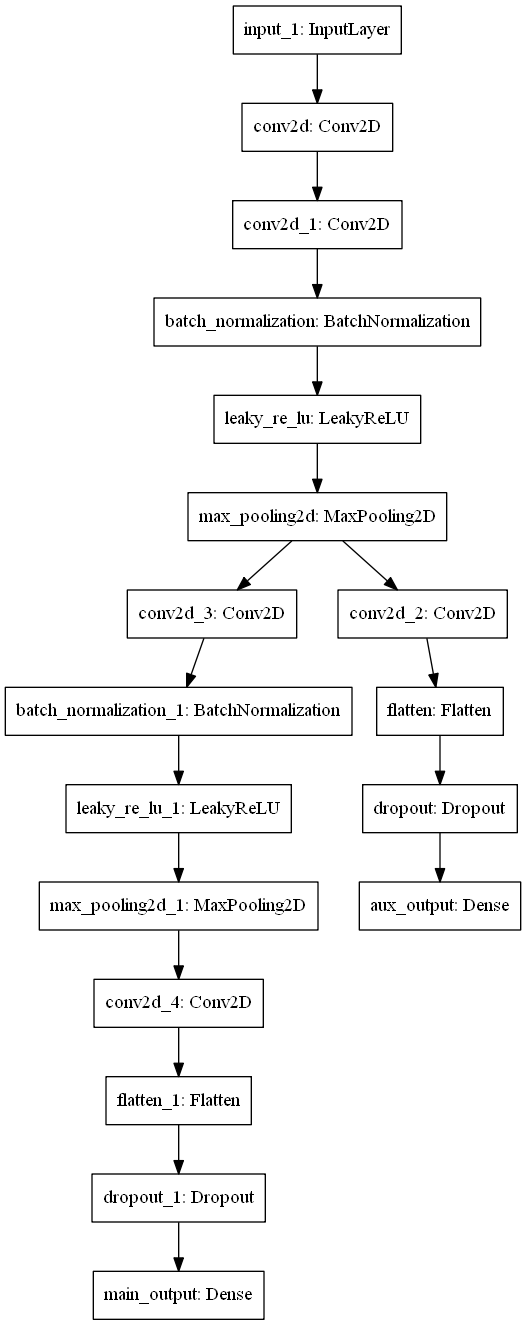

In [7]:
tf.keras.utils.plot_model(multi_out)

When we compile, train or call the model we can feed the inputs and the targets following the same order used defining the model (this can lead to confusion!) or by passing a dictionary using their names as keys.

In [8]:
multi_out.compile(loss={"aux_output": 'sparse_categorical_crossentropy',
                        "main_output": 'sparse_categorical_crossentropy'},
                  loss_weights={"aux_output": 0.3, "main_output": 0.7},
                  optimizer="RMSProp",
                  metrics=["accuracy"])

In [9]:
history_multi = multi_out.fit(x=x_train, y=(y_train, y_train),
                              batch_size=16, epochs=10,
                              validation_data=(x_val, (y_val, y_val)))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 86s 2ms/sample - loss: 0.4855 - main_output_loss: 0.4736 - aux_output_loss: 0.5129 - main_output_accuracy: 0.8340 - aux_output_accuracy: 0.8211 - val_loss: 0.3149 - val_main_output_loss: 0.2993 - val_aux_output_loss: 0.3518 - val_main_output_accuracy: 0.8908 - val_aux_output_accuracy: 0.8748
Epoch 2/10
55000/55000 [==============================] - 81s 1ms/sample - loss: 0.3478 - main_output_loss: 0.3345 - aux_output_loss: 0.3788 - main_output_accuracy: 0.8824 - aux_output_accuracy: 0.8651 - val_loss: 0.3033 - val_main_output_loss: 0.2867 - val_aux_output_loss: 0.3422 - val_main_output_accuracy: 0.8968 - val_aux_output_accuracy: 0.8792
Epoch 3/10
55000/55000 [==============================] - 86s 2ms/sample - loss: 0.3202 - main_output_loss: 0.3051 - aux_output_loss: 0.3556 - main_output_accuracy: 0.8937 - aux_output_accuracy: 0.8776 - val_loss: 0.3243 - val_main_output_loss: 0.32

KeyboardInterrupt: 

# Compare to single output

In [10]:
input_ = Input(shape=x_train[0].shape)
main_out, _ = build_model(input_)
single_out = tf.keras.Model(inputs=input_, outputs=main_out)
single_out.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1843

In [11]:
single_out.compile(loss='sparse_categorical_crossentropy',
                   optimizer="RMSProp",
                   metrics=["accuracy"])


In [12]:
history_single = single_out.fit(x=x_train, y=y_train,
                                batch_size=16, epochs=10,
                                validation_data=(x_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 83s 2ms/sample - loss: 0.4709 - accuracy: 0.8349 - val_loss: 0.3096 - val_accuracy: 0.8924
Epoch 2/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3286 - accuracy: 0.8838 - val_loss: 0.3097 - val_accuracy: 0.8920
Epoch 3/10
55000/55000 [==============================] - 72s 1ms/sample - loss: 0.3007 - accuracy: 0.8949 - val_loss: 0.2736 - val_accuracy: 0.9044
Epoch 4/10
55000/55000 [==============================] - 71s 1ms/sample - loss: 0.2816 - accuracy: 0.9012 - val_loss: 0.2529 - val_accuracy: 0.9132
Epoch 5/10
55000/55000 [==============================] - 71s 1ms/sample - loss: 0.2663 - accuracy: 0.9056 - val_loss: 0.2531 - val_accuracy: 0.9116
Epoch 6/10
55000/55000 [==============================] - 71s 1ms/sample - loss: 0.2566 - accuracy: 0.9105 - val_loss: 0.2572 - val_accuracy: 0.9116
Epoch 7/10
55000/55000 [==============================] -

NameError: name 'history_multi' is not defined

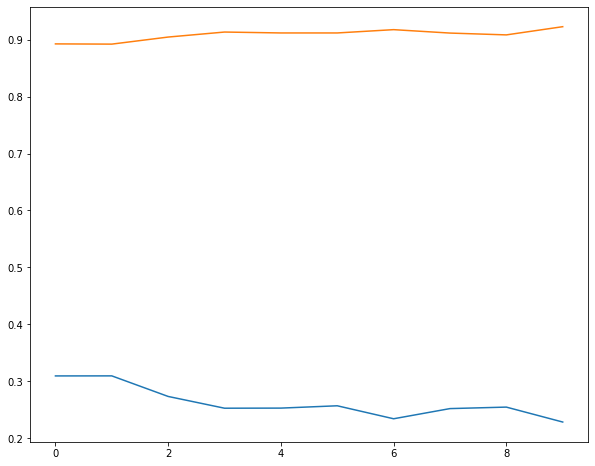

In [13]:
plt.figure(figsize=(10,8))

plt.plot(history_single.history['val_loss'], label='val_loss')
plt.plot(history_single.history['val_accuracy'], label='val_acc')
plt.plot(history_multi.history['val_loss'], label='multi: val_loss')
plt.plot(history_multi.history['val_main_output_accuracy'], label='multi: val_main_acc')
plt.legend()
plt.grid()
plt.xlabel('Epoch')

# Evaluate generalisation error
The very last thing to do. After this no more tuning, accept the result as it is.

In [14]:
print("### Single Output ###")
tot_loss, main_acc = single_out.evaluate(x_test, y_test)

print("Test total loss    : %.3f"%tot_loss)
print("Test accuracy: %.3f"%main_acc)
print("Generalisation error: %.3f"%(1-main_acc))

print("### Multi Output ###")
tot_loss, main_loss, aux_loss, main_acc, aux_acc = multi_out.evaluate(x_test, y_test)

print("Test total loss    : %.3f"%tot_loss)
print("Test accuracy: %.3f"%main_acc)
print("Generalisation error: %.3f"%(1-main_acc))

### Single Output ###
313/313 [==============================] - 1s 2ms/step - loss: 0.2383 - accuracy: 0.9177
Test total loss    : 0.238
Test accuracy: 0.918
Generalisation error: 0.082
### Multi Output ###
313/313 [==============================] - 1s 2ms/step - loss: 0.2531 - main_output_loss: 0.2427 - aux_output_loss: 0.2772 - main_output_accuracy: 0.9157 - aux_output_accuracy: 0.9026
Test total loss    : 0.253
Test accuracy: 0.916
Generalisation error: 0.084
